In [1]:
import numpy as np
import sys

sys.path.append('/home/aseem/python_modules/cosmology/')
from universe import Cosmology

from time import time
import gc

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol

In [2]:
import numpy as np
import sys

sys.path.append('/home/aseem/python_modules/cosmology/')
from universe import Cosmology

from time import time
import gc

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol

In [3]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Cosmological Parameter Variations
### Impact of varying Sahyadri cosmological parameters on non-linear cosmological statistics
Statistics explored <span style="color:red"> (all at $z=0$)</span>:
1. Non-linear matter power spectrum (HALOFIT)
2. Halo mass function (Tinker+ 2008)
3. Linear halo bias (Tinker+ 2010)

## Fiducial cosmology

In [4]:
# to control plots
Lbox = 200.0
Npart = 2048

In [5]:
Om = 0.3137721
Ob = 0.0493017
Ok = 0.0
h = 0.6736
ns = 0.9649
As = 2.098903e-9
w0 = -1.0

Pklin = 'class'

start_time = time()
co_fid = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
Dnl_fid = co_fid.nonlinearpower(model=1)
kvals = co_fid.ktab_lin*co_fid.hubble
co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.823
... done
Nonlinear power spectrum using HALOFIT: assumes flat LCDM.
HALOFIT parameters from Takahashi et al (2012)
0 min 3.53 seconds



## $\Omega_{\rm m} \pm 2\%$

In [6]:
DOm = 0.02*co_fid.Om

start_time = time()
co_Om_p = Cosmology(Om=Om+DOm,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Om_m = Cosmology(Om=Om-DOm,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Om_pp = Cosmology(Om=Om+2*DOm,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Om_mm = Cosmology(Om=Om-2*DOm,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)

Dnl_Om_p = co_Om_p.nonlinearpower(model=1)
Dnl_Om_pp = co_Om_pp.nonlinearpower(model=1)
Dnl_Om_m = co_Om_m.nonlinearpower(model=1)
Dnl_Om_mm = co_Om_mm.nonlinearpower(model=1)
co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3200,0.6799,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.835
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3075,0.6924,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.810
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3263,0.6736,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

## $\Omega_{\rm b} \pm 2\%$

In [7]:
DOb = 0.02*co_fid.Ob

start_time = time()
co_Ob_p = Cosmology(Om=Om,Ob=Ob+DOb,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Ob_m = Cosmology(Om=Om,Ob=Ob-DOb,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Ob_pp = Cosmology(Om=Om,Ob=Ob+2*DOb,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Ob_mm = Cosmology(Om=Om,Ob=Ob-2*DOb,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)

Dnl_Ob_p = co_Ob_p.nonlinearpower(model=1)
Dnl_Ob_pp = co_Ob_pp.nonlinearpower(model=1)
Dnl_Ob_m = co_Ob_m.nonlinearpower(model=1)
Dnl_Ob_mm = co_Ob_mm.nonlinearpower(model=1)
co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.05029,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.818
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04832,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.828
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.05127,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

## $n_{\rm s} \pm 2\%$

In [8]:
Dns = 0.02*co_fid.ns

start_time = time()
co_ns_p = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns+Dns,As=As,wDE0=w0,Pklin=Pklin)
co_ns_m = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns-Dns,As=As,wDE0=w0,Pklin=Pklin)
co_ns_pp = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns+2*Dns,As=As,wDE0=w0,Pklin=Pklin)
co_ns_mm = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns-2*Dns,As=As,wDE0=w0,Pklin=Pklin)

Dnl_ns_p = co_ns_p.nonlinearpower(model=1)
Dnl_ns_pp = co_ns_pp.nonlinearpower(model=1)
Dnl_ns_m = co_ns_m.nonlinearpower(model=1)
Dnl_ns_mm = co_ns_mm.nonlinearpower(model=1)
co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9842)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.829
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9456)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.817
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,1.0035)
... ... using CLASS
[....................] 100% done
... us

## $A_{\rm s} \pm 2\%$

In [9]:
DAs = 0.02*co_fid.As

start_time = time()
co_As_p = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As+DAs,wDE0=w0,Pklin=Pklin)
co_As_m = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As-DAs,wDE0=w0,Pklin=Pklin)
co_As_pp = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As+2*DAs,wDE0=w0,Pklin=Pklin)
co_As_mm = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As-2*DAs,wDE0=w0,Pklin=Pklin)

Dnl_As_p = co_As_p.nonlinearpower(model=1)
Dnl_As_pp = co_As_pp.nonlinearpower(model=1)
Dnl_As_m = co_As_m.nonlinearpower(model=1)
Dnl_As_mm = co_As_mm.nonlinearpower(model=1)
co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.064,0.831
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.024,0.814
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

## $h \pm 2\%$

In [10]:
Dh = 0.02*co_fid.hubble

start_time = time()
co_h_p = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h+Dh,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_h_m = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h-Dh,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_h_pp = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h+2*Dh,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_h_mm = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h-2*Dh,ns=ns,As=As,wDE0=w0,Pklin=Pklin)

Dnl_h_p = co_h_p.nonlinearpower(model=1)
Dnl_h_pp = co_h_pp.nonlinearpower(model=1)
Dnl_h_m = co_h_m.nonlinearpower(model=1)
Dnl_h_mm = co_h_mm.nonlinearpower(model=1)

# need interpolation since code internally uses h/Mpc units for k values
Dnl_h_p = np.exp(np.interp(np.log(kvals),np.log(co_h_p.ktab_lin*co_h_p.hubble),np.log(Dnl_h_p)))
Dnl_h_pp = np.exp(np.interp(np.log(kvals),np.log(co_h_pp.ktab_lin*co_h_pp.hubble),np.log(Dnl_h_pp)))
Dnl_h_m = np.exp(np.interp(np.log(kvals),np.log(co_h_m.ktab_lin*co_h_m.hubble),np.log(Dnl_h_m)))
Dnl_h_mm = np.exp(np.interp(np.log(kvals),np.log(co_h_m.ktab_lin*co_h_mm.hubble),np.log(Dnl_h_mm)))

co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6871,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.841
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6601,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.804
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.7005,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

## $\Omega_{\rm k} \pm 0.01$

In [11]:
DOk = 0.01

start_time = time()
co_Ok_p = Cosmology(Om=Om,Ob=Ob,Ok=Ok+DOk,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Ok_m = Cosmology(Om=Om,Ob=Ob,Ok=Ok-DOk,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Ok_pp = Cosmology(Om=Om,Ob=Ob,Ok=Ok+2*DOk,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)
co_Ok_mm = Cosmology(Om=Om,Ob=Ob,Ok=Ok-2*DOk,hubble=h,ns=ns,As=As,wDE0=w0,Pklin=Pklin)

Dnl_Ok_p = co_Ok_p.nonlinearpower(model=1)
Dnl_Ok_pp = co_Ok_pp.nonlinearpower(model=1)
Dnl_Ok_m = co_Ok_m.nonlinearpower(model=1)
Dnl_Ok_mm = co_Ok_mm.nonlinearpower(model=1)
co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6761,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.815
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6961,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.831
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6661,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
[....................] 100% done
... us

## $w_{0} \pm 2\%$ 
### <span style="color:red"> *not sure about growth factor* </span>.

In [12]:
Dw0 = 0.02*np.fabs(co_fid.wDE0)

start_time = time()
co_w0_p = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0+Dw0,Pklin=Pklin)
co_w0_m = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0-Dw0,Pklin=Pklin)
co_w0_pp = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0+2*Dw0,Pklin=Pklin)
co_w0_mm = Cosmology(Om=Om,Ob=Ob,Ok=Ok,hubble=h,ns=ns,As=As,wDE0=w0-2*Dw0,Pklin=Pklin)

Dnl_w0_p = co_w0_p.nonlinearpower(model=1)
Dnl_w0_pp = co_w0_pp.nonlinearpower(model=1)
Dnl_w0_m = co_w0_m.nonlinearpower(model=1)
Dnl_w0_mm = co_w0_mm.nonlinearpower(model=1)
co_fid.time_this(start_time)

... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
... ... ... dark energy EoS w0 = -0.980
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.819
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0.6736,0.8150,0.9649)
... ... using CLASS
... ... ... dark energy EoS w0 = -1.020
[....................] 100% done
... using As normalisation
... ln(1e10*As),sig8 = 3.044,0.827
... done
... initialising Cosmology()
... ... detected As normalisation, will override sig8.
... ... calculating linear power spectrum at present epoch
... ... cosmology (Om,OLam,Ob,h,sig8,ns) = (0.3138,0.6861,0.04930,0

# Plots

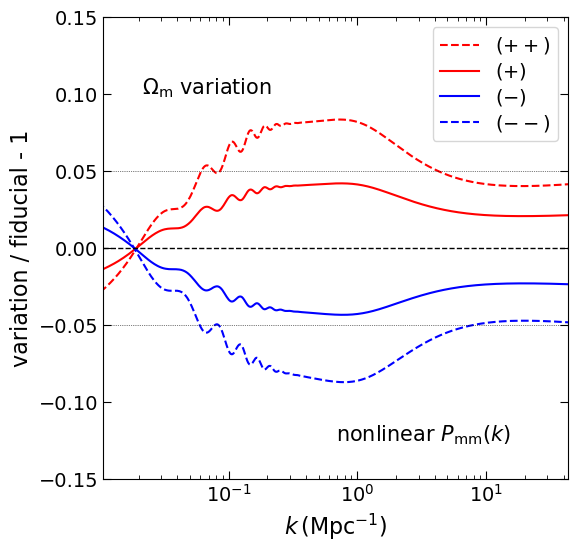

In [13]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.ylim(-0.15,0.15)
Xmin = 2*np.pi/Lbox/2*co_fid.hubble
Xmax = np.pi*Npart/Lbox*2*co_fid.hubble
plt.xlim(Xmin,Xmax)

plt.xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
plt.ylabel('variation / fiducial - 1')

plt.plot(kvals,Dnl_Om_pp/Dnl_fid-1,'r--',label='$(++)$')
plt.plot(kvals,Dnl_Om_p/Dnl_fid-1,'r-',label='$(+)$')
plt.plot(kvals,Dnl_Om_m/Dnl_fid-1,'b-',label='$(-)$')
plt.plot(kvals,Dnl_Om_mm/Dnl_fid-1,'b--',label='$(--)$')

plt.text(2*Xmin,0.1,"$\\Omega_{\\rm m}$ variation",fontsize=FS2)
plt.text(np.sqrt(Xmin*Xmax),-0.125,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
plt.axhline(0.0,c='k',ls='--',lw=1)
plt.axhline(0.05,c='k',ls=':',lw=0.5)
plt.axhline(-0.05,c='k',ls=':',lw=0.5)

plt.legend()
plt.show()

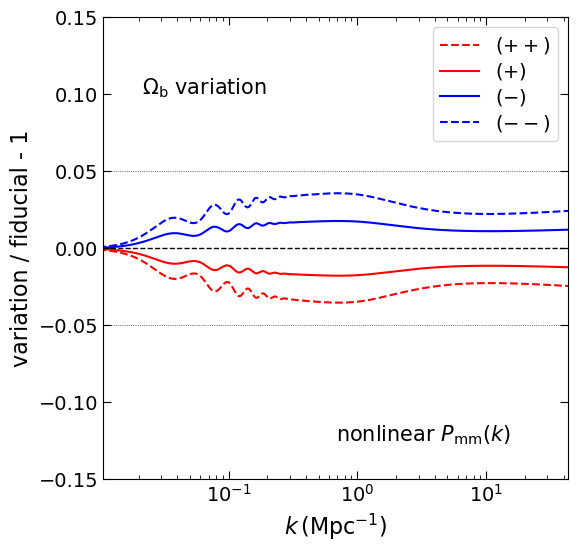

In [14]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.ylim(-0.15,0.15)
Xmin = 2*np.pi/Lbox/2*co_fid.hubble
Xmax = np.pi*Npart/Lbox*2*co_fid.hubble
plt.xlim(Xmin,Xmax)

plt.xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
plt.ylabel('variation / fiducial - 1')

plt.plot(kvals,Dnl_Ob_pp/Dnl_fid-1,'r--',label='$(++)$')
plt.plot(kvals,Dnl_Ob_p/Dnl_fid-1,'r-',label='$(+)$')
plt.plot(kvals,Dnl_Ob_m/Dnl_fid-1,'b-',label='$(-)$')
plt.plot(kvals,Dnl_Ob_mm/Dnl_fid-1,'b--',label='$(--)$')

plt.text(2*Xmin,0.1,"$\\Omega_{\\rm b}$ variation",fontsize=FS2)
plt.text(np.sqrt(Xmin*Xmax),-0.125,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
plt.axhline(0.0,c='k',ls='--',lw=1)
plt.axhline(0.05,c='k',ls=':',lw=0.5)
plt.axhline(-0.05,c='k',ls=':',lw=0.5)

plt.legend()
plt.show()

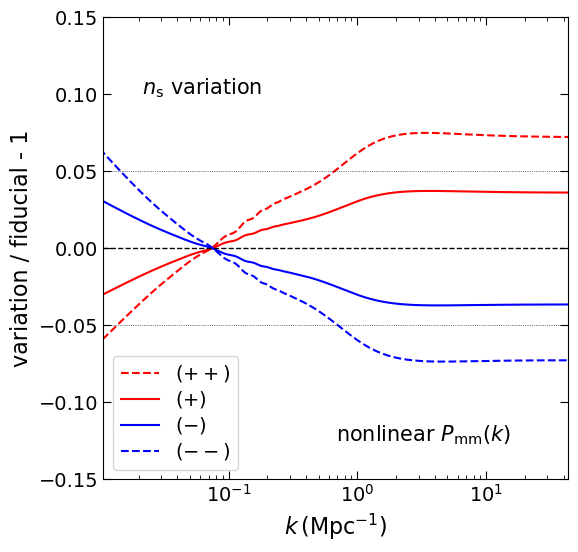

In [15]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.ylim(-0.15,0.15)
Xmin = 2*np.pi/Lbox/2*co_fid.hubble
Xmax = np.pi*Npart/Lbox*2*co_fid.hubble
plt.xlim(Xmin,Xmax)

plt.xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
plt.ylabel('variation / fiducial - 1')

plt.plot(kvals,Dnl_ns_pp/Dnl_fid-1,'r--',label='$(++)$')
plt.plot(kvals,Dnl_ns_p/Dnl_fid-1,'r-',label='$(+)$')
plt.plot(kvals,Dnl_ns_m/Dnl_fid-1,'b-',label='$(-)$')
plt.plot(kvals,Dnl_ns_mm/Dnl_fid-1,'b--',label='$(--)$')

plt.text(2*Xmin,0.1,"$n_{\\rm s}$ variation",fontsize=FS2)
plt.text(np.sqrt(Xmin*Xmax),-0.125,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
plt.axhline(0.0,c='k',ls='--',lw=1)
plt.axhline(0.05,c='k',ls=':',lw=0.5)
plt.axhline(-0.05,c='k',ls=':',lw=0.5)

plt.legend(loc='lower left')
plt.show()

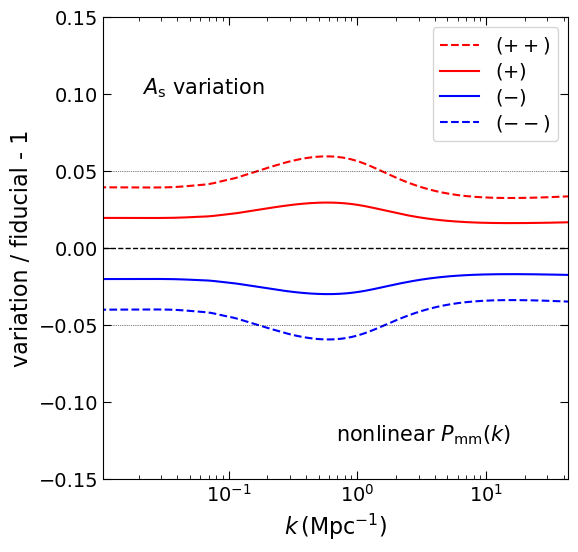

In [16]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.ylim(-0.15,0.15)
Xmin = 2*np.pi/Lbox/2*co_fid.hubble
Xmax = np.pi*Npart/Lbox*2*co_fid.hubble
plt.xlim(Xmin,Xmax)

plt.xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
plt.ylabel('variation / fiducial - 1')

plt.plot(kvals,Dnl_As_pp/Dnl_fid-1,'r--',label='$(++)$')
plt.plot(kvals,Dnl_As_p/Dnl_fid-1,'r-',label='$(+)$')
plt.plot(kvals,Dnl_As_m/Dnl_fid-1,'b-',label='$(-)$')
plt.plot(kvals,Dnl_As_mm/Dnl_fid-1,'b--',label='$(--)$')

plt.text(2*Xmin,0.1,"$A_{\\rm s}$ variation",fontsize=FS2)
plt.text(np.sqrt(Xmin*Xmax),-0.125,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
plt.axhline(0.0,c='k',ls='--',lw=1)
plt.axhline(0.05,c='k',ls=':',lw=0.5)
plt.axhline(-0.05,c='k',ls=':',lw=0.5)

plt.legend()
plt.show()

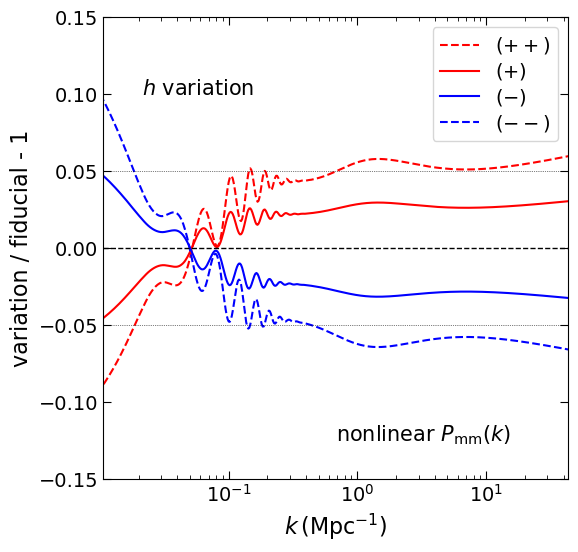

In [17]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.ylim(-0.15,0.15)
Xmin = 2*np.pi/Lbox/2*co_fid.hubble
Xmax = np.pi*Npart/Lbox*2*co_fid.hubble
plt.xlim(Xmin,Xmax)

plt.xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
plt.ylabel('variation / fiducial - 1')

plt.plot(kvals,Dnl_h_pp/Dnl_fid-1,'r--',label='$(++)$')
plt.plot(kvals,Dnl_h_p/Dnl_fid-1,'r-',label='$(+)$')
plt.plot(kvals,Dnl_h_m/Dnl_fid-1,'b-',label='$(-)$')
plt.plot(kvals,Dnl_h_mm/Dnl_fid-1,'b--',label='$(--)$')

plt.text(2*Xmin,0.1,"$h$ variation",fontsize=FS2)
plt.text(np.sqrt(Xmin*Xmax),-0.125,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
plt.axhline(0.0,c='k',ls='--',lw=1)
plt.axhline(0.05,c='k',ls=':',lw=0.5)
plt.axhline(-0.05,c='k',ls=':',lw=0.5)

plt.legend()
plt.show()

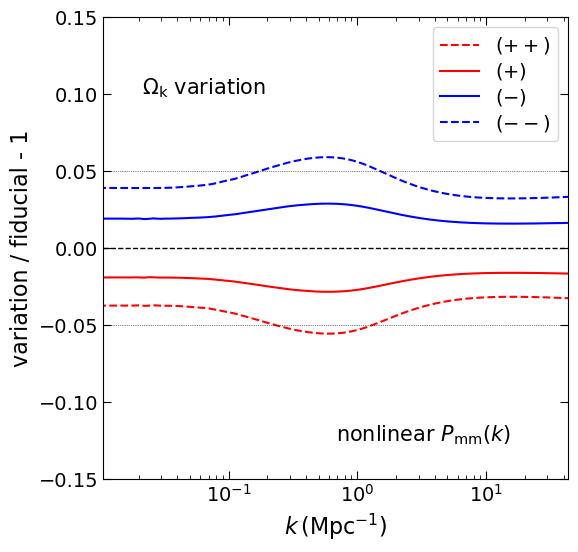

In [18]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.ylim(-0.15,0.15)
Xmin = 2*np.pi/Lbox/2*co_fid.hubble
Xmax = np.pi*Npart/Lbox*2*co_fid.hubble
plt.xlim(Xmin,Xmax)

plt.xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
plt.ylabel('variation / fiducial - 1')

plt.plot(kvals,Dnl_Ok_pp/Dnl_fid-1,'r--',label='$(++)$')
plt.plot(kvals,Dnl_Ok_p/Dnl_fid-1,'r-',label='$(+)$')
plt.plot(kvals,Dnl_Ok_m/Dnl_fid-1,'b-',label='$(-)$')
plt.plot(kvals,Dnl_Ok_mm/Dnl_fid-1,'b--',label='$(--)$')

plt.text(2*Xmin,0.1,"$\\Omega_{\\rm k}$ variation",fontsize=FS2)
plt.text(np.sqrt(Xmin*Xmax),-0.125,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
plt.axhline(0.0,c='k',ls='--',lw=1)
plt.axhline(0.05,c='k',ls=':',lw=0.5)
plt.axhline(-0.05,c='k',ls=':',lw=0.5)

plt.legend()
plt.show()

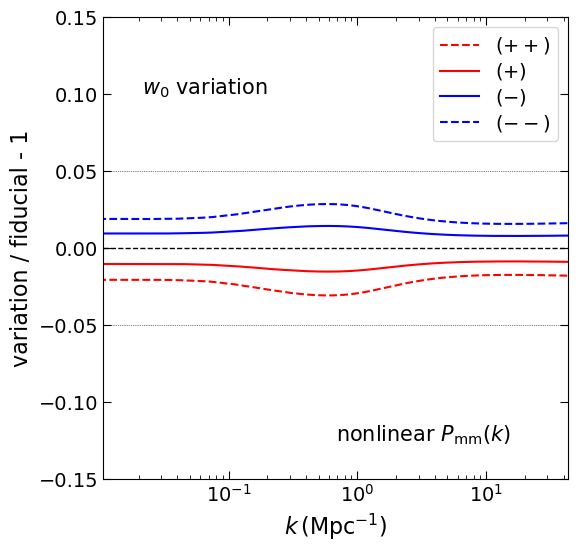

In [19]:
plt.figure(figsize=(6,6))
plt.xscale('log')
plt.ylim(-0.15,0.15)
Xmin = 2*np.pi/Lbox/2*co_fid.hubble
Xmax = np.pi*Npart/Lbox*2*co_fid.hubble
plt.xlim(Xmin,Xmax)

plt.xlabel("$k\\,({\\rm Mpc}^{{-1}})$")
plt.ylabel('variation / fiducial - 1')

plt.plot(kvals,Dnl_w0_pp/Dnl_fid-1,'r--',label='$(++)$')
plt.plot(kvals,Dnl_w0_p/Dnl_fid-1,'r-',label='$(+)$')
plt.plot(kvals,Dnl_w0_m/Dnl_fid-1,'b-',label='$(-)$')
plt.plot(kvals,Dnl_w0_mm/Dnl_fid-1,'b--',label='$(--)$')

plt.text(2*Xmin,0.1,"$w_{0}$ variation",fontsize=FS2)
plt.text(np.sqrt(Xmin*Xmax),-0.125,'nonlinear $P_{{\\rm mm}}(k)$',fontsize=FS2)
plt.axhline(0.0,c='k',ls='--',lw=1)
plt.axhline(0.05,c='k',ls=':',lw=0.5)
plt.axhline(-0.05,c='k',ls=':',lw=0.5)

plt.legend()
plt.show()